In [1]:
import pandas as pd
import pypsa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['font.family'] = 'serif'

In [2]:
network = pypsa.Network()
hours_in_2015 = pd.date_range('2015-01-01 00:00Z',
                              '2015-12-31 23:00Z',
                              freq='h')

network.set_snapshots(hours_in_2015.values)

network.add("Bus",
            "electricity bus")

network.snapshots

c:\Users\carlo\miniconda3\envs\integrated-energy-grids\Lib\site-packages\pypsa\components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\carlo\miniconda3\envs\integrated-energy-grids\Lib\site-packages\pypsa\components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\carlo\miniconda3\envs\integrated-energy-grids\Lib\site-packages\pypsa\components.py:323: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pand

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)

In [3]:
# load electricity demand data
df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
country='GBR'
print(df_elec[country].head())

utc_time
2015-01-01 00:00:00+00:00    29059.0
2015-01-01 01:00:00+00:00    28663.0
2015-01-01 02:00:00+00:00    26626.0
2015-01-01 03:00:00+00:00    24778.0
2015-01-01 04:00:00+00:00    23212.0
Name: GBR, dtype: float64


In [4]:
# add load to the bus
network.add("Load",
            "load",
            bus="electricity bus",
            p_set=df_elec[country].values)

In [5]:
network.loads_t.p_set

Load,load
snapshot,
2015-01-01 00:00:00,29059.0
2015-01-01 01:00:00,28663.0
2015-01-01 02:00:00,26626.0
2015-01-01 03:00:00,24778.0
2015-01-01 04:00:00,23212.0
...,...
2015-12-31 19:00:00,35944.0
2015-12-31 20:00:00,33128.0
2015-12-31 21:00:00,30488.0


In [6]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n

In [7]:
# CAPEX values for different technologies (in €/MW)
offshoreWind_capex = 2.8e6
onshoreWind_capex = 1.4e6
solar_capex = 628e3
ccgt_capex = 1.04e6
nuclear_capex = 11.08e6

# add the different carriers, only gas emits CO2
network.add("Carrier", "gas", co2_emissions=0.2019) # in t_CO2/MWh_th
network.add("Carrier", "onshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "offshorewind")
network.add("Carrier", "nuclear")

# add onshore wind generator
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_windOnshore = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_onshorewind = annuity(25,0.07)*onshoreWind_capex * (1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
network.add("Generator",
            "onshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="onshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_onshorewind,
            marginal_cost = 0,
            p_max_pu = CF_windOnshore.values)

# add offshore wind generator
df_offshore = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshore.index = pd.to_datetime(df_offshore.index)
CF_windOffshore = df_offshore[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_offshore = annuity(25,0.07)*offshoreWind_capex *(1+0.03) # in €/MW !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
network.add("Generator",
            "offshorewind",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshore,
            marginal_cost = 0,
            p_max_pu = CF_windOffshore.values)

# add solar PV generator
df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)
CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
capital_cost_solar = annuity(25,0.07)*solar_capex*(1+0.03) # in €/MW
network.add("Generator",
            "solar",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar.values)

# add CCGT (Combine Cycle Gas Turbine) generator
capital_cost_CCGT = annuity(30,0.07)*(ccgt_capex + 14.32 * 1000) # in €/MW
fuel_cost = 30.32 # in €/MWh_th
efficiency = 0.5 # MWh_elec/MWh_th
marginal_cost_CCGT = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "CCGT",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_CCGT,
            marginal_cost = marginal_cost_CCGT)

# add nuclear generator
capital_cost_nuclear = annuity(40,0.07)*(nuclear_capex + 14.45 * 1000) # in €/MW
fuel_cost = 6.2 # in €/MWh_th
efficiency = 0.33 # MWh_elec/MWh_th
marginal_cost_nuclear = fuel_cost/efficiency # in €/MWh_el
network.add("Generator",
            "nuclear",
            bus="electricity bus",
            p_nom_extendable=True,
            carrier="nuclear",
            #p_nom_max=1000,
            capital_cost = capital_cost_nuclear,
            marginal_cost = marginal_cost_nuclear)

In [8]:
network.generators_t.p_max_pu

Generator,onshorewind,offshorewind,solar
snapshot,,,
2015-01-01 00:00:00,0.606,0.601,0.0
2015-01-01 01:00:00,0.610,0.569,0.0
2015-01-01 02:00:00,0.592,0.538,0.0
2015-01-01 03:00:00,0.570,0.539,0.0
2015-01-01 04:00:00,0.552,0.561,0.0
...,...,...,...
2015-12-31 19:00:00,0.508,0.735,0.0
2015-12-31 20:00:00,0.426,0.666,0.0
2015-12-31 21:00:00,0.336,0.554,0.0


In [9]:
network.optimize(solver_name='gurobi', Outputflag = 0)

c:\Users\carlo\miniconda3\envs\integrated-energy-grids\Lib\site-packages\pypsa\optimization\constraints.py:531: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  .groupby(n.loads.bus, axis=1)
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - Outputflag: 0


Set parameter Username


INFO:gurobipy:Set parameter Username


Set parameter LicenseID to value 2587918


INFO:gurobipy:Set parameter LicenseID to value 2587918


Academic license - for non-commercial use only - expires 2025-11-20


INFO:gurobipy:Academic license - for non-commercial use only - expires 2025-11-20
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 33.41it/s]
INFO:linopy.io: Writing time: 0.45s


Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-96usx8y_.lp


INFO:gurobipy:Read LP format model from file C:\Users\carlo\AppData\Local\Temp\linopy-problem-96usx8y_.lp


Reading time = 0.13 seconds


INFO:gurobipy:Reading time = 0.13 seconds


obj: 96365 rows, 43805 columns, 170959 nonzeros


INFO:gurobipy:obj: 96365 rows, 43805 columns, 170959 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 43805 primals, 96365 duals
Objective: 2.08e+10
Solver model: available
Solver message: 2

c:\Users\carlo\miniconda3\envs\integrated-energy-grids\Lib\site-packages\pypsa\optimization\optimize.py:355: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  n.df(c)[attr + "_opt"].update(df)
INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lowe

('ok', 'optimal')

In [10]:
print(network.objective/1000000) #in 10^6 €

20772.93169833319


In [11]:
print(network.objective/network.loads_t.p.sum()) # EUR/MWh

Load
load    73.611927
dtype: float64


In [17]:
network.generators.p_nom_opt # in MW

Generator
onshorewind     49966.804979
offshorewind        0.000000
solar               0.000000
CCGT            49928.659751
nuclear             0.000000
Name: p_nom_opt, dtype: float64

<h2>Plot a week in winter</h2>

C:\Users\carlo\AppData\Local\Temp\ipykernel_25188\2492626160.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')


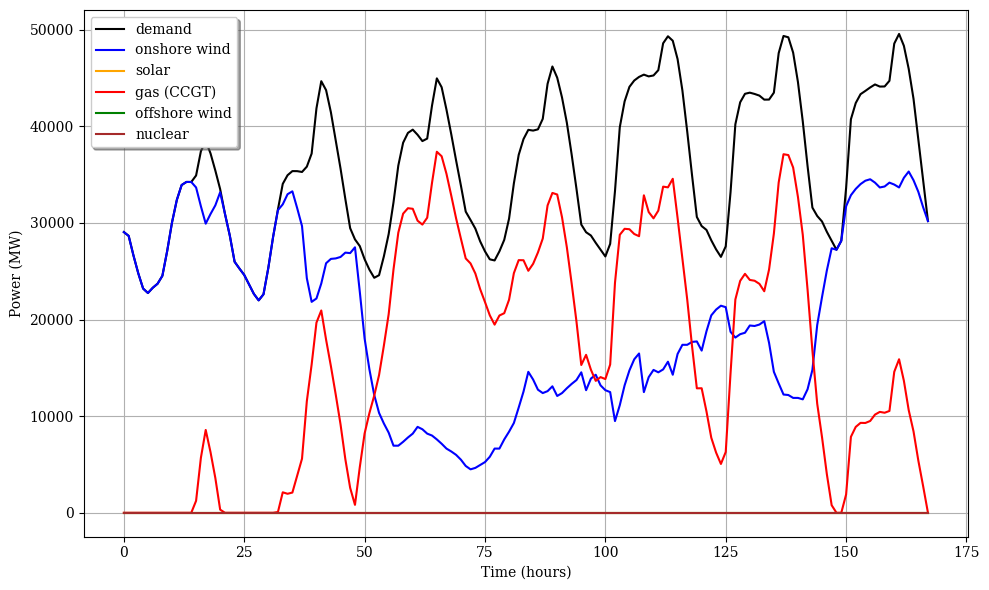

In [13]:
num_hours_week = 7 * 24

hours = pd.date_range(start="2015-01-01", periods=num_hours_week, freq='H')
demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

plt.figure(figsize=(10, 6))
plt.plot(demand, color='black', label='demand')
plt.plot(onshore_wind, color='blue', label='onshore wind')
plt.plot(solar, color='orange', label='solar')
plt.plot(gas_ccgt, color='red', label='gas (CCGT)')
plt.plot(offshore_wind, color='green', label='offshore wind')
plt.plot(nuclear, color='brown', label='nuclear')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
#plt.title('Energy Production and Demand')
# plt.xticks(rotation=45)
plt.grid(True)

# Improve x-axis ticks
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(12))
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(3))
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()


<h2>Plot a week in summer</h2>

C:\Users\carlo\AppData\Local\Temp\ipykernel_25188\832826849.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hours = pd.date_range(start="2015-01-06", periods=num_hours_week, freq='H')


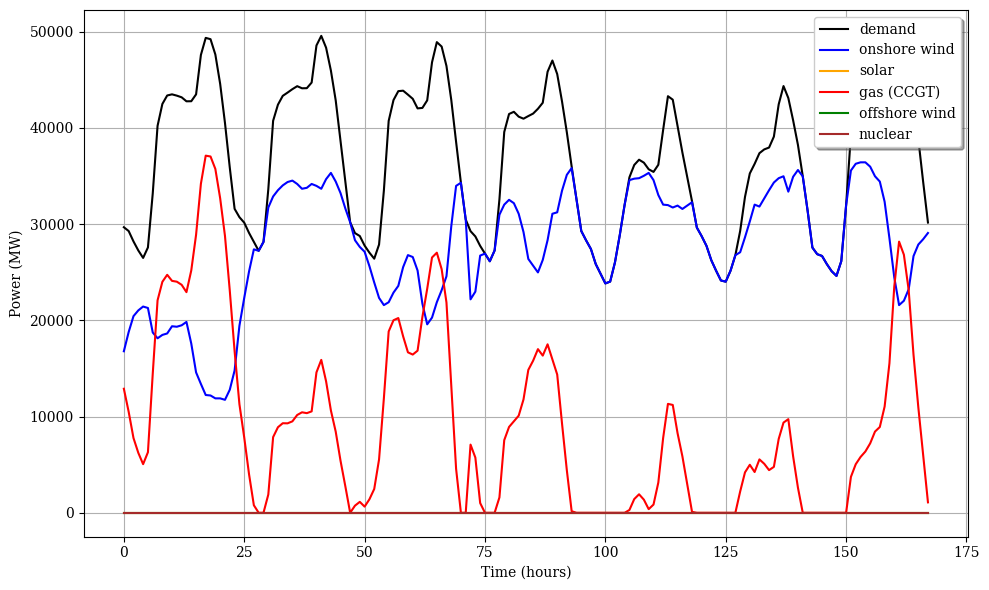

In [14]:
num_hours_week = 7 * 24

hours = pd.date_range(start="2015-01-06", periods=num_hours_week, freq='H')
demand = network.loads_t.p['load'][hours].values
onshore_wind = network.generators_t.p['onshorewind'][hours].values
solar = network.generators_t.p['solar'][hours].values    
gas_ccgt = network.generators_t.p['CCGT'][hours].values
offshore_wind = network.generators_t.p['offshorewind'][hours].values
nuclear = network.generators_t.p['nuclear'][hours].values

plt.figure(figsize=(10, 6))
plt.plot(demand, color='black', label='demand')
plt.plot(onshore_wind, color='blue', label='onshore wind')
plt.plot(solar, color='orange', label='solar')
plt.plot(gas_ccgt, color='red', label='gas (CCGT)')
plt.plot(offshore_wind, color='green', label='offshore wind')
plt.plot(nuclear, color='brown', label='nuclear')
plt.legend(fancybox=True, shadow=True, loc='best')
plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
#plt.title('Energy Production and Demand')
# plt.xticks(rotation=45)
plt.grid(True)

# Improve x-axis ticks
# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(48))
# plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(3))
# plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()


Text(0.5, 1.07, 'Electricity mix')

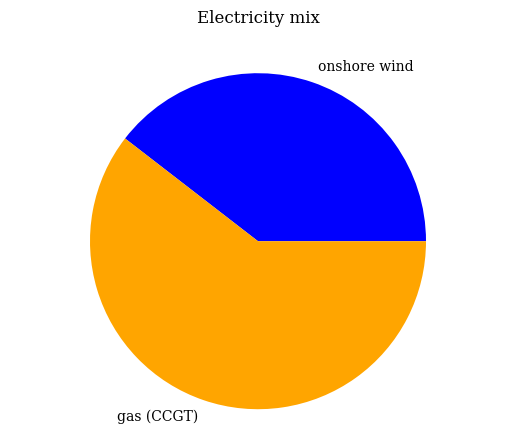

In [18]:
labels = ['onshore wind',
          'gas (CCGT)']
sizes = [network.generators_t.p['onshorewind'].sum(),
         network.generators_t.p['CCGT'].sum(),
]

colors=['blue', 'orange', 'brown', 'green', 'red']

plt.pie(sizes,
        colors=colors,
        labels=labels,
        wedgeprops={'linewidth':0})
plt.axis('equal')

plt.title('Electricity mix', y=1.07)

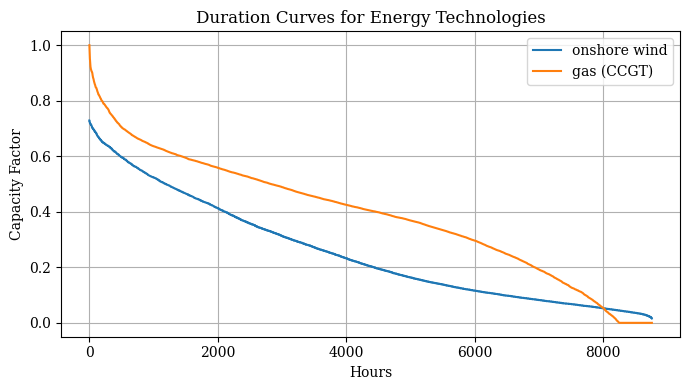

In [16]:
# Capacity factor calculation
capacity_factors = {
    "onshore wind": network.generators_t.p['onshorewind'] / network.generators.p_nom_opt['onshorewind'],
    "gas (CCGT)": network.generators_t.p['CCGT'] / network.generators.p_nom_opt['CCGT']
}

# Sorting data for duration curve plot
duration_curves = {
    tech: np.sort(data)[::-1]
    for tech, data in capacity_factors.items()
}

# Plotting the duration curves
plt.figure(figsize=(7, 4))
for tech, data in duration_curves.items():
    plt.plot(data, label=tech)

plt.title('Duration Curves for Energy Technologies')
plt.xlabel('Hours')
plt.ylabel('Capacity Factor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
